### Encode Node Features

In [ ]:
import torch
from torch_geometric.data import HeteroData
import torch.nn as nn
from torch_geometric.nn import NNConv, global_mean_pool 
import torch.optim as optim
from torch_geometric.nn import GlobalAttention

In [ ]:
import torch

# Load the hetero graph
data = torch.load("Graph_Results/HeteroGraphs_ScaledFinal/HeteroGraph_T1.pt")

# Print node types and sizes
print("Node Types and Features:")
for ntype in data.node_types:
    print(f"  {ntype}: {data[ntype].x.shape}")

# Print edge types and count
print("\nEdge Types:")
for etype in data.edge_types:
    edge_index = data[etype].edge_index
    print(f"  {etype}: {edge_index.shape[1]} edges")

# Check a few values from cell node features
print("\nSample cell node features (first 5 rows):")
print(data["cell"].x[:5])


In [ ]:
import torch.nn as nn

class NodeFeatureEncoders(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.cell_encoder = nn.Sequential(
            nn.Linear(7, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),  # 🔁 Replaced BatchNorm1d
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.gene_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),  # 🔁 Replaced BatchNorm1d
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.pathway_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),  # 🔁 Replaced BatchNorm1d
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

    def forward(self, cell_x, gene_x, pathway_x):
        h_cell = self.cell_encoder(cell_x)
        h_gene = self.gene_encoder(gene_x)
        h_pathway = self.pathway_encoder(pathway_x)
        return h_cell, h_gene, h_pathway


###  Shared Hierarchical Encoder with Virtual Node Implementation

In [ ]:
from torch_geometric.nn import GlobalAttention

class GlobalAttentionWithWeights(GlobalAttention):
    def forward(self, x, index, ptr=None, dim_size=None, dim=0):
        """
        x: Node embeddings
        index: Index tensor (typically the batch vector)
        """
        gate = self.gate_nn(x).squeeze(-1)      # [N]
        gate = torch.sigmoid(gate)              # attention weights
        x_weighted = x * gate.unsqueeze(-1)     # [N, F]

        # Perform aggregation (mean by default)
        out = torch.zeros(dim_size or int(index.max()) + 1, x.size(-1), device=x.device)
        out = out.index_add(dim, index, x_weighted)

        return out, gate

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import NNConv

class SharedHierarchicalEncoder(nn.Module):
    def __init__(self, hidden_dim=64, num_dosages=9, num_aux_outputs=1):
        super().__init__()

        self.node_encoders = NodeFeatureEncoders(hidden_dim)

        self.dosage_embeddings = nn.Embedding(num_dosages, hidden_dim)
        self.virtual_norm = nn.LayerNorm(hidden_dim)

        self.dosage_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        self.fuse_cell_virtual = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        self.fuse_gene_virtual = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        self.fuse_pathway_virtual = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        self.edge_mlp_cell_gene = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * hidden_dim)
        )
        self.edge_mlp_gene_pathway = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * hidden_dim)
        )

        self.cell_to_gene_conv = NNConv(hidden_dim, hidden_dim, self.edge_mlp_cell_gene, aggr='mean')
        self.gene_to_pathway_conv = NNConv(hidden_dim, hidden_dim, self.edge_mlp_gene_pathway, aggr='mean')

        self.att_pool = GlobalAttentionWithWeights(gate_nn=nn.Linear(hidden_dim, 1))

        self.fuse_global = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        self.aux_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_aux_outputs)
        )

    def refine_virtuals_with_lstm(self):
        raw_dosage_embeddings = self.dosage_embeddings.weight.unsqueeze(0)
        lstm_out, _ = self.dosage_lstm(raw_dosage_embeddings)
        return self.virtual_norm(lstm_out.squeeze(0))

    def forward(self, data, dosage_idx):
        cell_x, gene_x, pathway_x = data["cell"].x, data["gene"].x, data["pathway"].x
        h_cell, h_gene, h_pathway = self.node_encoders(cell_x, gene_x, pathway_x)

        refined_dosage_virtuals = self.refine_virtuals_with_lstm()
        dosage_virtual = refined_dosage_virtuals[dosage_idx]

        # Inject dosage virtual into cell nodes
        num_cells = h_cell.size(0)
        h_cell = self.fuse_cell_virtual(torch.cat([
            h_cell,
            dosage_virtual.unsqueeze(0).expand(num_cells, -1)
        ], dim=1))

        # Inject dosage virtual into gene nodes
        num_genes = h_gene.size(0)
        h_gene = self.fuse_gene_virtual(torch.cat([
            h_gene,
            dosage_virtual.unsqueeze(0).expand(num_genes, -1)
        ], dim=1))

        edge_index_cg = data["cell", "expresses", "gene"].edge_index
        edge_attr_cg = data["cell", "expresses", "gene"].edge_attr
        h_gene_updated = self.cell_to_gene_conv((h_cell, h_gene), edge_index_cg, edge_attr_cg)

        # Inject dosage virtual into pathway nodes
        num_pathways = h_pathway.size(0)
        h_pathway = self.fuse_pathway_virtual(torch.cat([
            h_pathway,
            dosage_virtual.unsqueeze(0).expand(num_pathways, -1)
        ], dim=1))

        edge_index_gp = data["gene", "involved_in", "pathway"].edge_index
        edge_attr_gp = data["gene", "involved_in", "pathway"].edge_attr
        h_pathway_updated = self.gene_to_pathway_conv((h_gene_updated, h_pathway), edge_index_gp, edge_attr_gp)

        pooled_pathway, pathway_attention_weights = self.att_pool(h_pathway_updated, data['pathway'].batch)

        graph_embedding = self.fuse_global(torch.cat([
            pooled_pathway,
            dosage_virtual.unsqueeze(0)
        ], dim=1))

        aux_output = self.aux_head(graph_embedding)

        # ✅ Normalize node embeddings before output
        h_cell = F.normalize(h_cell, p=2, dim=-1)
        h_gene_updated = F.normalize(h_gene_updated, p=2, dim=-1)
        h_pathway_updated = F.normalize(h_pathway_updated, p=2, dim=-1)

        return {
            "h_cell": h_cell,
            "h_gene": h_gene_updated,
            "h_pathway": h_pathway_updated,
            "dosage_virtual": dosage_virtual,
            "graph_embedding": graph_embedding,
            "aux_output": aux_output.squeeze(),
            "pathway_attention_weights": pathway_attention_weights
        }


## Decoder Architecture Implementation

In [ ]:
import torch
import torch.nn as nn

class HierarchicalDecoder(nn.Module):
    def __init__(self, hidden_dim=64, cell_feature_dim=7):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cell_feature_dim = cell_feature_dim

        self.gene_query_bias = nn.Parameter(torch.randn(1, hidden_dim))
        self.cell_query_bias = nn.Parameter(torch.randn(1, hidden_dim))

        self.decode_to_pathways_fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
        )
        self.decode_to_pathways_proj = nn.Linear(hidden_dim, hidden_dim)

        self.pathway_to_gene_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=2,
            dropout=0.1,
            batch_first=True
        )
        self.gene_to_cell_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=2,
            dropout=0.1,
            batch_first=True
        )

        self.dropout = nn.Dropout(0.1)

        self.decode_to_cells = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, cell_feature_dim)
        )

        self.aux_pathway_score_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
        )
        self.aux_resistance_predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, h_pathway_updated, h_gene_updated, graph_embedding, dosage_virtual, num_genes, num_cells,
                gene_mask=None, cell_mask=None):
        # 🔁 Updated to handle non-batch input
        num_pathways, _ = h_pathway_updated.size()
        B = 1

        if graph_embedding.dim() == 3:
            graph_embedding = graph_embedding.squeeze(1)  # [1, 1, 64] → [1, 64]
        graph_expanded = graph_embedding.unsqueeze(1).expand(B, num_pathways, -1)
        h_pathway_expanded = h_pathway_updated.unsqueeze(0)  # [1, P, 64]

        combined_input = torch.cat([h_pathway_expanded, graph_expanded], dim=2)
        base_pathway_repr = self.decode_to_pathways_fc(combined_input)
        pathway_recon = self.decode_to_pathways_proj(base_pathway_repr)

        gene_seed = h_pathway_updated.mean(dim=0)  # [64]
        gene_query = gene_seed.unsqueeze(0).unsqueeze(1).expand(B, num_genes, -1) + self.gene_query_bias

        gene_recon_raw, attn_pathway_gene = self.pathway_to_gene_attn(
            gene_query, pathway_recon, pathway_recon, key_padding_mask=gene_mask
        )
        gene_recon_raw = self.dropout(gene_recon_raw)
        gene_recon = gene_recon_raw + gene_query

        cell_seed = h_gene_updated.mean(dim=0)
        cell_query = cell_seed.unsqueeze(0).unsqueeze(1).expand(B, num_cells, -1) + self.cell_query_bias

        cell_recon_raw, attn_gene_cell = self.gene_to_cell_attn(
            cell_query, gene_recon, gene_recon, key_padding_mask=cell_mask
        )
        cell_recon_raw = self.dropout(cell_recon_raw)
        cell_embedding_for_resistance = cell_recon_raw + cell_query  # 🔁 use this
        cell_recon = self.decode_to_cells(cell_embedding_for_resistance)
        
        aux_pathway_scores = self.aux_pathway_score_head(pathway_recon).squeeze(-1)
        aux_resistance_score = self.aux_resistance_predictor(cell_embedding_for_resistance).squeeze(-1)  # 🔁 fix here

        return {
            "reconstructed_pathways": pathway_recon.squeeze(0),
            "reconstructed_genes": gene_recon.squeeze(0),
            "reconstructed_cells": cell_recon.squeeze(0),
            "aux_pathway_scores": aux_pathway_scores.squeeze(0),
            "aux_resistance_score": aux_resistance_score,  # shape: [num_cells]
            "attention_pathway_to_gene": attn_pathway_gene,
            "attention_gene_to_cell": attn_gene_cell
        }


## Test Loaded Graph

In [ ]:
import torch
from torch_geometric.data import HeteroData

# Load one example graph (change path if needed)
graph_path = 'Graph_Results/HeteroGraphs_ScaledFinal/HeteroGraph_T1.pt'
data = torch.load(graph_path)

print(f"Inspecting graph at: {graph_path}")
print("=" * 50)

# Node types
print("\n📦 Node Types and Feature Shapes:")
for node_type in data.node_types:
    x = data[node_type].x
    print(f"- {node_type}: {x.shape} features, dtype: {x.dtype}")
    if hasattr(data[node_type], 'batch'):
        print(f"  Batch attribute: {data[node_type].batch.shape}")
    print(f"  Feature stats: min {x.min().item()}, max {x.max().item()}, mean {x.mean().item()}")

# Edge types
print("\n🔗 Edge Types and Attributes:")
for edge_type in data.edge_types:
    edge_index = data[edge_type].edge_index
    edge_attr = data[edge_type].edge_attr
    print(f"- {edge_type}: {edge_index.shape[1]} edges, edge_attr shape: {edge_attr.shape}")
    print(f"  Edge attr stats: min {edge_attr.min().item()}, max {edge_attr.max().item()}, mean {edge_attr.mean().item()}")

# Summary counts
print("\n📊 Summary:")
print(f"- Total node types: {len(data.node_types)}")
print(f"- Total edge types: {len(data.edge_types)}")
total_nodes = sum(data[node_type].num_nodes for node_type in data.node_types)
print(f"- Total nodes: {total_nodes}")
total_edges = sum(data[edge_type].edge_index.shape[1] for edge_type in data.edge_types)
print(f"- Total edges: {total_edges}")

# Optional: inspect one example feature vector
for node_type in data.node_types:
    print(f"\nExample {node_type} feature vector (first node):")
    print(data[node_type].x[0])


## Loss desgin

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HierarchicalLoss(nn.Module):
    def __init__(self, 
                  lambda_pathway=2.0,     # 🔺 Highest priority
                 lambda_gene=1.0,        # 🔸 Medium priority
                 lambda_cell=0.5,        # 🔻 Lowest priority
                 lambda_resistance=0.1, 
                 lambda_attention=0.01,
                 use_resistance=True,
                 use_attention_reg=True):
        super().__init__()
        self.lambda_pathway = lambda_pathway
        self.lambda_gene = lambda_gene
        self.lambda_cell = lambda_cell
        self.lambda_resistance = lambda_resistance
        self.lambda_attention = lambda_attention
        self.use_resistance = use_resistance
        self.use_attention_reg = use_attention_reg

    def forward(self, outputs, targets):
        """
        outputs: dict from decoder
        targets: dict from encoder and ground truth features:
            - h_pathway
            - h_gene
            - cell_features
            - resistance_label (optional)
        """

        # 1️⃣ Pathway-level reconstruction
        L_pathway = F.mse_loss(outputs["reconstructed_pathways"], targets["h_pathway"])

        # 2️⃣ Gene-level reconstruction
        L_gene = F.mse_loss(outputs["reconstructed_genes"], targets["h_gene"])

        # 3️⃣ Cell-level reconstruction
        L_cell = F.mse_loss(outputs["reconstructed_cells"], targets["cell_features"])

        # 4️⃣ Resistance prediction (if available)
        # 4️⃣ Resistance prediction (if available)
        if self.use_resistance and "resistance_label" in targets:
            L_resistance = F.mse_loss(outputs["aux_resistance_score"].squeeze(0), targets["resistance_label"])
        else:
            L_resistance = torch.tensor(0.0, device=L_cell.device)


        # 5️⃣ Attention entropy regularization (optional)
        if self.use_attention_reg:
            attn_weights = outputs["attention_pathway_to_gene"]
            attn_weights = torch.clamp(attn_weights, min=1e-6)
            L_attention = -(attn_weights * torch.log(attn_weights)).sum(dim=-1).mean()
        else:
            L_attention = torch.tensor(0.0, device=L_cell.device)

        # ✅ Total Loss
        total_loss = (
            self.lambda_pathway * L_pathway +
            self.lambda_gene * L_gene +
            self.lambda_cell * L_cell +
            self.lambda_resistance * L_resistance +
            self.lambda_attention * L_attention
        )

        # 🔍 Log individual loss components
        loss_dict = {
            "total_loss": total_loss.item(),
            "pathway_loss": L_pathway.item(),
            "gene_loss": L_gene.item(),
            "cell_loss": L_cell.item(),
            "resistance_loss": L_resistance.item(),
            "attention_reg_loss": L_attention.item()
        }

        return total_loss, loss_dict


In [ ]:
# import torch
# from torch.optim import Adam
# from tqdm import tqdm

# def train_encoder_decoder_model(
#     encoder, decoder, graphs, dosage_to_idx, optimizer=None, device='cuda',
#     epochs=100, loss_weights=None, save_path=None
# ):
#     if loss_weights is None:
#         # Updated weight priority: pathway > gene > cell
#         loss_weights = {
#             'lambda_pathway': 2.0,
#             'lambda_gene': 1.0,
#             'lambda_cell': 0.3,
#             'lambda_resistance': 0.1,
#             'lambda_attention': 0.01
#         }

#     encoder = encoder.to(device)
#     decoder = decoder.to(device)

#     # ✅ Unpack weights into the HierarchicalLoss class
#     criterion = HierarchicalLoss(**loss_weights).to(device)

#     if optimizer is None:
#         optimizer = Adam(
#             list(encoder.parameters()) + list(decoder.parameters()),
#             lr=1e-3,
#             weight_decay=1e-5
#         )

#     loss_log = []

#     for epoch in range(epochs):
#         encoder.train()
#         decoder.train()
#         total_loss = 0.0
#         epoch_loss_dict = {
#             'pathway_loss': 0.0,
#             'gene_loss': 0.0,
#             'cell_loss': 0.0,
#             'resistance_loss': 0.0,
#             'attention_reg_loss': 0.0,
#             'total_loss': 0.0
#         }

#         for dosage_name, graph in graphs.items():
#             data = graph.to(device)
#             dosage_idx = dosage_to_idx[dosage_name]  # E.g., T10 → 10
#             if not hasattr(data['pathway'], 'batch'):
#                 data['pathway'].batch = torch.zeros(data['pathway'].num_nodes, dtype=torch.long, device=data['pathway'].x.device)

#                # -------- Forward -------- #
#             encoder_out = encoder(data, dosage_idx)
#             decoder_out = decoder(
#                 h_pathway_updated=encoder_out['h_pathway'],  # [P, 64]
#                 h_gene_updated=encoder_out['h_gene'],        # [G, 64]
#                 graph_embedding=encoder_out['graph_embedding'].unsqueeze(0),  # keep batch dimension
#                 dosage_virtual=encoder_out['dosage_virtual'].unsqueeze(0),    # keep batch dimension
#                 num_genes=encoder_out['h_gene'].shape[0],
#                 num_cells=encoder_out['h_cell'].shape[0]
#             )

#             # -------- Targets -------- #
#             targets = {
#                 'h_pathway': encoder_out['h_pathway'].detach(),  # Ground truth: original encoder output
#                 'h_gene': encoder_out['h_gene'].detach(),
#                 'cell_features': data['cell'].x,
#                 'resistance_label': data['cell'].x[:, 2]  # Assumes resistance encoded at index 2
#             }

#             # -------- Loss -------- #
#             loss, loss_components = criterion(decoder_out, targets)
#             total_loss += loss.item()
#             for key in epoch_loss_dict:
#                 epoch_loss_dict[key] += loss_components[key]

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         # Average losses
#         num_graphs = len(graphs)
#         avg_loss_dict = {k: v / num_graphs for k, v in epoch_loss_dict.items()}
#         loss_log.append(avg_loss_dict)

#         print(f"Epoch {epoch+1:03d} | "
#               f"Total: {avg_loss_dict['total_loss']:.4f} | "
#               f"P: {avg_loss_dict['pathway_loss']:.4f}, "
#               f"G: {avg_loss_dict['gene_loss']:.4f}, "
#               f"C: {avg_loss_dict['cell_loss']:.4f}, "
#               f"R: {avg_loss_dict['resistance_loss']:.4f}, "
#               f"A: {avg_loss_dict['attention_reg_loss']:.4f}")

#     # Optional model saving
#     if save_path:
#         torch.save({'encoder': encoder.state_dict(),
#                     'decoder': decoder.state_dict()}, save_path)
#         print(f"✅ Model saved to {save_path}")

#     return encoder, decoder, loss_log


In [ ]:
import torch
import json
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_encoder_decoder_model(
    encoder, decoder, graphs, dosage_to_idx, optimizer=None, device='cuda',
    epochs=100, loss_weights=None, save_path=None,
    attention_lambda_warmup_epochs=10,
    early_stop_patience=10
):
    if loss_weights is None:
        loss_weights = {
            'lambda_pathway': 2.0,
            'lambda_gene': 1.0,
            'lambda_cell': 0.3,
            'lambda_resistance': 0.1,
            'lambda_attention': 0.01,
            'use_attention_reg': True
        }

    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Initial loss object (will re-init if lambda_attention changes)
    criterion = HierarchicalLoss(**loss_weights).to(device)

    if optimizer is None:
        optimizer = Adam(
            list(encoder.parameters()) + list(decoder.parameters()),
            lr=1e-3,
            weight_decay=1e-5
        )

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-5)
    best_loss = float('inf')
    no_improvement_epochs = 0
    loss_log = []

    for epoch in range(epochs):
        # 🔁 Warm-up: gradually increase lambda_attention
        if loss_weights["use_attention_reg"] and epoch < attention_lambda_warmup_epochs:
            warmup_lambda = (epoch + 1) / attention_lambda_warmup_epochs * 0.01  # final lambda_attention target
            loss_weights["lambda_attention"] = warmup_lambda
            criterion = HierarchicalLoss(**loss_weights).to(device)

        encoder.train()
        decoder.train()

        epoch_loss_dict = {
            'pathway_loss': 0.0,
            'gene_loss': 0.0,
            'cell_loss': 0.0,
            'resistance_loss': 0.0,
            'attention_reg_loss': 0.0,
            'total_loss': 0.0
        }

        for dosage_name, graph in graphs.items():
            data = graph.to(device)
            dosage_idx = dosage_to_idx[dosage_name]

            if not hasattr(data['pathway'], 'batch'):
                data['pathway'].batch = torch.zeros(data['pathway'].num_nodes, dtype=torch.long, device=device)

            encoder_out = encoder(data, dosage_idx)
            decoder_out = decoder(
                h_pathway_updated=encoder_out['h_pathway'],
                h_gene_updated=encoder_out['h_gene'],
                graph_embedding=encoder_out['graph_embedding'].unsqueeze(0),
                dosage_virtual=encoder_out['dosage_virtual'].unsqueeze(0),
                num_genes=encoder_out['h_gene'].shape[0],
                num_cells=encoder_out['h_cell'].shape[0]
            )

            targets = {
                'h_pathway': encoder_out['h_pathway'].detach(),
                'h_gene': encoder_out['h_gene'].detach(),
                'cell_features': data['cell'].x,
                'resistance_label': data['cell'].x[:, 2]
            }

            loss, loss_components = criterion(decoder_out, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for key in epoch_loss_dict:
                epoch_loss_dict[key] += loss_components[key]

        # Average loss across all graphs
        num_graphs = len(graphs)
        avg_loss_dict = {k: v / num_graphs for k, v in epoch_loss_dict.items()}
        loss_log.append(avg_loss_dict)

        print(f"Epoch {epoch+1:03d} | Total: {avg_loss_dict['total_loss']:.4f} | "
              f"P: {avg_loss_dict['pathway_loss']:.4f}, "
              f"G: {avg_loss_dict['gene_loss']:.4f}, "
              f"C: {avg_loss_dict['cell_loss']:.4f}, "
              f"R: {avg_loss_dict['resistance_loss']:.4f}, "
              f"A: {avg_loss_dict['attention_reg_loss']:.6f}")

        # Monitor loss for scheduler and early stopping
        monitored = avg_loss_dict['total_loss']
        scheduler.step(monitored)

        if monitored < best_loss - 1e-4:
            best_loss = monitored
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= early_stop_patience:
            print(f"🛑 Early stopping at epoch {epoch+1}, no improvement in {early_stop_patience} epochs.")
            break

    # Save model and logs
    if save_path:
        torch.save({'encoder': encoder.state_dict(), 'decoder': decoder.state_dict()}, save_path)
        print(f"✅ Model saved to {save_path}")
        with open(save_path.replace('.pth', '_loss_log.json'), 'w') as f:
            json.dump(loss_log, f, indent=2)
        print(f"📉 Loss log saved to {save_path.replace('.pth', '_loss_log.json')}")

    return encoder, decoder, loss_log


In [ ]:
import os
import torch

def load_all_dosage_graphs(graph_dir, pattern_prefix="HeteroGraph_T"):
    """
    Loads all dosage-specific heterographs from the specified directory.

    Args:
        graph_dir (str): Path to directory containing dosage graphs.
        pattern_prefix (str): File prefix to identify graph files (e.g., "HeteroGraph_T").

    Returns:
        dict: A dictionary { "T1": data_obj, "T10": data_obj, ... }
    """
    graphs = {}
    for fname in os.listdir(graph_dir):
        if fname.startswith(pattern_prefix) and fname.endswith(".pt"):
            dosage_key = fname.replace(".pt", "").replace(pattern_prefix, "T")
            path = os.path.join(graph_dir, fname)
            data = torch.load(path)
            graphs[dosage_key] = data
    return graphs


In [ ]:


# Load graphs
graph_dir = "Graph_Results/HeteroGraphs_ScaledFinal"
graphs = load_all_dosage_graphs(graph_dir)

# 🔁 Map 'T2.5', 'T10', etc. to integer indices
dosage_levels = sorted([float(k.replace('T', '')) for k in graphs.keys()])
dosage_to_idx = {f"T{int(d) if d.is_integer() else d}": i for i, d in enumerate(dosage_levels)}

# Load model
encoder = SharedHierarchicalEncoder(hidden_dim=64, num_dosages=len(dosage_to_idx))
decoder = HierarchicalDecoder(hidden_dim=64, cell_feature_dim=7)

# Train
trained_encoder, trained_decoder, loss_log = train_encoder_decoder_model(
    encoder, decoder, graphs, dosage_to_idx=dosage_to_idx,
    device='cpu', epochs=100, save_path="trained_model12.pth"
)


### Loss Analysis

## Represesntation of the Model Analysis

In [ ]:
# Load model with correct dosage count used during training
encoder = SharedHierarchicalEncoder(hidden_dim=64, num_dosages=9)
decoder = HierarchicalDecoder(hidden_dim=64, cell_feature_dim=7)

# Load checkpoint
checkpoint = torch.load("trained_model12.pth", map_location='cpu')
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

encoder.eval()
decoder.eval()


In [ ]:
graph_dir = "Graph_Results/HeteroGraphs_ScaledFinal"
graphs = load_all_dosage_graphs(graph_dir)

# Also ensure you have dosage_to_idx mapping
dosage_to_idx = {k: i for i, k in enumerate(sorted(graphs.keys(), key=lambda x: float(x[1:])))}


In [ ]:
all_outputs = {}
device = torch.device('cpu')

for dosage_name, data in graphs.items():
    data = data.to(device)
    dosage_idx = dosage_to_idx[dosage_name]

    # ✅ Inject dummy batch for pathway
    if not hasattr(data['pathway'], 'batch'):
        data['pathway'].batch = torch.zeros(data['pathway'].num_nodes, dtype=torch.long, device=data['pathway'].x.device)

    # Encoder
    with torch.no_grad():
        encoder_out = encoder(data, dosage_idx)
        decoder_out = decoder(
            h_pathway_updated=encoder_out['h_pathway'],   # [1, P, 64]
            h_gene_updated=encoder_out['h_gene'],         # [1, G, 64]
            graph_embedding=encoder_out['graph_embedding'].unsqueeze(0).squeeze(1),  # [1, 64]
            dosage_virtual=encoder_out['dosage_virtual'].unsqueeze(0),
            num_genes=encoder_out['h_gene'].shape[0],
            num_cells=encoder_out['h_cell'].shape[0]
        )



    all_outputs[dosage_name] = {
        "encoder": encoder_out,
        "decoder": decoder_out
    }


In [ ]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Path to graph mappings
graph_mapping_dir = "Graph_Results/Graph_Mappings"
embedding_records = []

# Extract embeddings
for dosage_name, output in all_outputs.items():
    mapping_path = os.path.join(graph_mapping_dir, f"Graph_Mapping_{dosage_name}.json")
    if not os.path.exists(mapping_path):
        continue

    with open(mapping_path, 'r') as f:
        mapping = json.load(f)

    h_gene = output["encoder"]["h_gene"]
    h_pathway = output["encoder"]["h_pathway"]

    for gene, idx in mapping["gene_to_index"].items():
        embedding_records.append({
            "type": "gene",
            "name": gene,
            "dosage": dosage_name,
            "embedding": h_gene[idx].tolist()
        })

    for pathway, idx in mapping["pathway_to_index"].items():
        embedding_records.append({
            "type": "pathway",
            "name": pathway,
            "dosage": dosage_name,
            "embedding": h_pathway[idx].tolist()
        })

# Prepare data
df_embed = pd.DataFrame(embedding_records)
embedding_matrix = np.vstack(df_embed["embedding"].values)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')
tsne_result = tsne.fit_transform(embedding_matrix)

df_embed["tsne-1"] = tsne_result[:, 0]
df_embed["tsne-2"] = tsne_result[:, 1]

# Save embeddings
df_embed.to_csv("tSNE_Embeddings_All_original.csv", index=False)

# Set global font size (optional)
plt.rcParams.update({'font.size': 12})

# Plot gene embeddings
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_embed[df_embed["type"] == "gene"],
    x="tsne-1", y="tsne-2", hue="dosage", palette="tab10"
)
plt.title("t-SNE: Gene Embeddings by Dose", fontsize=16)
plt.xlabel("tSNE-1", fontsize=14)
plt.ylabel("tSNE-2", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Dosage", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.savefig("tSNE_Gene_Embeddings_original.png", dpi=600, bbox_inches='tight')
plt.show()

# Plot pathway embeddings
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_embed[df_embed["type"] == "pathway"],
    x="tsne-1", y="tsne-2", hue="dosage", palette="tab10"
)
plt.title("t-SNE: Pathway Embeddings by Dose", fontsize=16)
plt.xlabel("tSNE-1", fontsize=14)
plt.ylabel("tSNE-2", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Dosage", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.savefig("tSNE_Pathway_Embeddings_original.png", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import numpy as np
import pandas as pd

# Load the t-SNE embedding file
df_embed = pd.read_csv("tSNE_Embeddings_All_original.csv")

# Step 1: Group embeddings
grouped_embeddings = defaultdict(lambda: defaultdict(list))
for _, row in df_embed.iterrows():
    entity_type = row["type"]
    name = row["name"]
    dosage = row["dosage"]
    emb = np.array(row["embedding"].strip('[]').split(','), dtype=float) if isinstance(row["embedding"], str) else row["embedding"]
    grouped_embeddings[entity_type][name].append((dosage, emb))

# Step 2: Define dosage order (make sure to sort properly based on true dosage value)
dosage_order = ['T1', 'T2.5', 'T5', 'T10', 'T20', 'T40', 'T80', 'T160', 'T320']
dosage_to_index = {d: i for i, d in enumerate(dosage_order)}

def compute_cosine_drift(embedding_dict):
    drift_dict = {}
    for name, entries in embedding_dict.items():
        # Filter valid entries by dosage order
        entries_sorted = sorted(entries, key=lambda x: dosage_to_index.get(x[0], -1))
        drifts = []
        for (d1, v1), (d2, v2) in zip(entries_sorted[:-1], entries_sorted[1:]):
            sim = cosine_similarity([v1], [v2])[0, 0]
            drift = 1 - sim
            drifts.append(drift)
        if drifts:
            drift_dict[name] = {
                "drifts": drifts,
                "mean_drift": np.mean(drifts),
                "num_pairs": len(drifts)
            }
    return drift_dict

# Step 3: Compute drifts
gene_drift = compute_cosine_drift(grouped_embeddings['gene'])
pathway_drift = compute_cosine_drift(grouped_embeddings['pathway'])

# Step 4: Compute overall mean drift
mean_gene_drift = np.mean([v["mean_drift"] for v in gene_drift.values()])
mean_pathway_drift = np.mean([v["mean_drift"] for v in pathway_drift.values()])

print(f"📊 Average Gene Drift Across Dosages: {mean_gene_drift:.4f}")
print(f"📊 Average Pathway Drift Across Dosages: {mean_pathway_drift:.4f}")

# Step 5: Save detailed drift information
pd.DataFrame([
    {"Gene": k, "MeanDrift": v["mean_drift"], "Pairs": v["num_pairs"]}
    for k, v in gene_drift.items()
]).to_csv("Gene_Cosine_Drift.csv", index=False)

pd.DataFrame([
    {"Pathway": k, "MeanDrift": v["mean_drift"], "Pairs": v["num_pairs"]}
    for k, v in pathway_drift.items()
]).to_csv("Pathway_Cosine_Drift.csv", index=False)


### Figure 1: Gene Embeddings by Dosage (t-SNE)

Clear Separation: Each dosage group (T1 to T320) forms a distinct cluster. This means the model has successfully learned distinct gene-level representations per dosage.

Smooth Transitions: The relative positions of T1 → T2.5 → T5 → T10 → T20 → T40 → T80 → T160 → T320 show a smooth progression, indicating that gene embeddings evolve gradually with increasing drug pressure.

Biological Insight:

This supports your hypothesis of adaptive reprogramming: genes shift in embedding space as resistance increases.

Potential to quantify embedding drift between adjacent dosages.

###  Figure 2: Pathway Embeddings by Dosage (t-SNE)
Distinct Clusters with Overlaps:

Like genes, pathways also form distinct clusters per dosage, indicating condition-specific pathway activation.

Some overlap (e.g., T10 and T20 clusters slightly closer) suggests shared pathways or transition zones.

Elongated Clusters:

The shape and orientation may indicate heterogeneity within each dosage—especially under partial resistance conditions (e.g., T80 or T160).

Good candidate for analyzing which pathways change activation most drastically.



In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances

# Define dosage order
dosage_order = ["T1", "T2.5", "T5", "T10", "T20", "T40", "T80", "T160", "T320"]

# Lists to store drift values
gene_drift, pathway_drift, transitions = [], [], []

# Compute cosine drift between adjacent dosages
for i in range(len(dosage_order) - 1):
    d1, d2 = dosage_order[i], dosage_order[i + 1]
    transitions.append(f"{d1}→{d2}")

    h_gene_1 = all_outputs[d1]['encoder']['h_gene']
    h_gene_2 = all_outputs[d2]['encoder']['h_gene']
    h_pathway_1 = all_outputs[d1]['encoder']['h_pathway']
    h_pathway_2 = all_outputs[d2]['encoder']['h_pathway']

    # Align dimensions
    min_gene = min(h_gene_1.shape[0], h_gene_2.shape[0])
    min_pathway = min(h_pathway_1.shape[0], h_pathway_2.shape[0])
    h_gene_1, h_gene_2 = h_gene_1[:min_gene], h_gene_2[:min_gene]
    h_pathway_1, h_pathway_2 = h_pathway_1[:min_pathway], h_pathway_2[:min_pathway]

    # Compute mean cosine distances
    gene_distance = cosine_distances(h_gene_1.numpy(), h_gene_2.numpy()).mean()
    pathway_distance = cosine_distances(h_pathway_1.numpy(), h_pathway_2.numpy()).mean()

    gene_drift.append(gene_distance)
    pathway_drift.append(pathway_distance)

# --- Plot Gene Drift ---
plt.figure(figsize=(8, 6))
plt.plot(transitions, gene_drift, marker='o', color='blue')
plt.title("Gene Embedding Drift", fontsize=16)
plt.xlabel("Dosage Transition", fontsize=14)
plt.ylabel("Mean Cosine Distance", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("gene_embedding_drift.png", dpi=600)
plt.show()

# --- Plot Pathway Drift ---
plt.figure(figsize=(8, 6))
plt.plot(transitions, pathway_drift, marker='o', color='green')
plt.title("Pathway Embedding Drift", fontsize=16)
plt.xlabel("Dosage Transition", fontsize=14)
plt.ylabel("Mean Cosine Distance", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("pathway_embedding_drift.png", dpi=600)
plt.show()


###  Gene Embedding Drift (Left Plot)
T1 → T2.5 → T5 → T10 → T20 shows progressively increasing drift, peaking at T20, suggesting:

Significant molecular reprogramming is happening in this early-to-mid dosage range.

Cells are likely undergoing transcriptional rewiring under increasing drug stress.

T20 → T40 drops sharply, then jumps at T80.

This dip may indicate temporary stabilization or selection of resistant subpopulations.

T80 still shows a high drift, suggesting further adaptation or new resistance mechanisms.

### Pathway Embedding Drift (Right Plot)
A similar trend:

Low drift from T1–T5,

Peak drift at T20, suggesting pathway reorganization happens most intensely here.

T20 → T40 again shows a drop, confirming a potential "rewiring event" that stabilizes after the system reorients.



### Gene Embedding Drift Plot (Left)
What It Shows:
The cosine distance between gene embeddings of consecutive dosages reflects how much the overall regulatory behavior of genes changes.

Biological Interpretation:
T1 → T2.5 → T10 → T20:

Increasing distance means that more genes are changing their roles, activation levels, or co-expression relationships.

This suggests gradual transcriptional adaptation to increasing drug pressure.

T20 has peak drift:

Indicates a critical threshold where the cell overhauls its transcriptional program — possibly switching to alternative survival mechanisms or activating stress-response modules.

Could involve:

Downregulation of apoptosis genes

Upregulation of DNA repair, efflux pumps, or metabolic shift genes

T20 → T40: Sharp drop

Suggests the cell has found a stable resistant state — no longer needing to adapt drastically.

Biological rewiring may have completed here, forming a resistant phenotype.

T40 → T80: rise again

Indicates secondary rewiring — possibly due to new drug toxicity or further resistance layer building.

### Pathway Embedding Drift Plot (Right)
T1 to T20: gradual then steep drift — shows pathway-level coordination changes.

Pathway rewiring means:

Activation/inhibition of entire biological processes, not just individual genes.

E.g., switching from p53 signaling to PI3K/AKT survival pathways, or activating autophagy.

T20 to T40 drop: implies the cell stabilizes around certain survival pathways.

T80 jump: maybe a new set of pathways activated for sustained resistance or metabolic compensation.
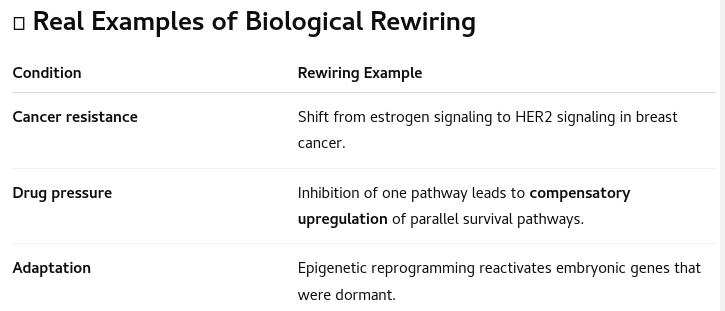

In [ ]:
import torch
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances

# --- Extract standardized pathway identifiers ---
def extract_pathway_identifier(name):
    """
    Extracts a Reactome ID (R-HSA: or r-hsa-) or GO ID (GO:) from a pathway name.
    Returns the matched identifier in standard form (uppercase), or None if not found.
    """
    # Match Reactome (r-hsa:123456 or R-HSA-123456)
    match_reactome = re.search(r"(r-hsa[-:]\d+)", name, flags=re.IGNORECASE)
    if match_reactome:
        return match_reactome.group(1).upper().replace(":", "-")

    # Match GO term (GO:0000000)
    match_go = re.search(r"(GO:\d+)", name, flags=re.IGNORECASE)
    if match_go:
        return match_go.group(1).upper()

    return None


# --- Load mappings and encoder outputs ---
def load_embeddings_and_mappings(dosage_names, encoder_outputs, mapping_dir):
    gene_embeddings_by_dosage = {}
    pathway_embeddings_by_dosage = {}
    gene_id_sets = []

    for dosage_name in dosage_names:
        with open(os.path.join(mapping_dir, f"Graph_Mapping_{dosage_name}.json")) as f:
            mapping = json.load(f)

        gene_map = mapping["gene_to_index"]
        pathway_map = mapping["pathway_to_index"]

        inv_gene_map = {v: k for k, v in gene_map.items()}

        # Extract and clean pathway IDs
        inv_pathway_map_raw = {v: extract_pathway_identifier(k) for k, v in pathway_map.items()}
        inv_pathway_map = {k: v for k, v in inv_pathway_map_raw.items() if v is not None}

        h_gene = encoder_outputs[dosage_name]["encoder"]["h_gene"]
        h_pathway = encoder_outputs[dosage_name]["encoder"]["h_pathway"]

        gene_embeddings_by_dosage[dosage_name] = {
            inv_gene_map[i]: h_gene[i].cpu().numpy() for i in range(len(h_gene))
        }
        pathway_embeddings_by_dosage[dosage_name] = {
            inv_pathway_map[i]: h_pathway[i].cpu().numpy() for i in range(len(h_pathway))
            if i in inv_pathway_map
        }

        gene_id_sets.append(set(gene_map.keys()))

    return gene_embeddings_by_dosage, pathway_embeddings_by_dosage


# --- Compute cosine drift across consecutive dosages ---
def compute_pairwise_drift(entity_dict, dosage_order):
    """
    Computes total pairwise cosine drift across consecutive dosages for each entity.
    Returns DataFrame with index=entity, column="Total_Drift".
    """
    entity_ids = set.intersection(*[set(entity_dict[d].keys()) for d in dosage_order])
    drift_scores = {}

    for entity in entity_ids:
        vectors = [entity_dict[d][entity] for d in dosage_order]
        total_drift = 0.0
        for i in range(len(vectors) - 1):
            v1 = vectors[i].reshape(1, -1)
            v2 = vectors[i + 1].reshape(1, -1)
            drift = cosine_distances(v1, v2)[0][0]
            total_drift += drift
        drift_scores[entity] = total_drift

    return pd.DataFrame.from_dict(drift_scores, orient="index", columns=["Total_Drift"])


# --- Plot top rewired genes/pathways ---
def plot_top_rewiring(drift_df, top_n=50, title="", entity_type="Gene", save_path=None):
    """
    Plots top-N rewired entities (genes or pathways) based on total cosine drift.
    """
    top_drift = drift_df.sort_values("Total_Drift", ascending=False).head(top_n)

    fig, ax = plt.subplots(figsize=(max(8, top_n * 0.25), 6))  # dynamic width
    bars = ax.bar(top_drift.index, top_drift["Total_Drift"], color="slateblue")

    ax.set_xticks(range(len(top_drift)))
    ax.set_xticklabels(top_drift.index, rotation=90)
    ax.set_ylabel("Total Cosine Drift")
    ax.set_title(title or f"Top {top_n} Rewired {entity_type}s Across Dosage")

    plt.subplots_adjust(bottom=0.3)  # extra margin for long labels

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=600, bbox_inches="tight")
        plt.close()
    else:
        plt.show()


In [ ]:
# Example usage:
mapping_dir = "Graph_Results/Graph_Mappings"
dosage_names = sorted(all_outputs.keys(), key=lambda x: float(x[1:]))  # works with T2.5, T10, etc.


gene_dict, pathway_dict = load_embeddings_and_mappings(dosage_names, all_outputs, mapping_dir)

# Drift
gene_drift = compute_pairwise_drift(gene_dict, dosage_names)
pathway_drift = compute_pairwise_drift(pathway_dict, dosage_names)

plot_top_rewiring(
    gene_drift,
    top_n=30,
    title="Top 30 Rewired Genes Across Dosage",
    entity_type="Gene",
    save_path="Plots/Gene_Rewired_Top30.png"
)

plot_top_rewiring(
    pathway_drift,
    top_n=30,
    title="Top 30 Rewired Pathways Across Dosage",
    entity_type="Pathway",
    save_path="Plots/Pathway_Rewired_Top30.png"
)



### Intra Dosage state analysis

In [ ]:
# Check unique state labels present in T10
import torch

state_labels = graphs["T10"]["cell"].x[:, 2]
print("Unique resistance states in T10:", torch.unique(state_labels))


In [ ]:
import torch
import matplotlib.pyplot as plt
import umap
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

# Extract cell embeddings and state labels from T10
h_cell = all_outputs["T10"]["encoder"]["h_cell"]  # [N_cells, 64]
state_feats = graphs["T10"]["cell"].x[:, 2:]       # One-hot resistance state

# Determine state label per cell (0-indexed: State_1 → label 0, etc.)
state_labels = state_feats.argmax(dim=1)

# Filter for State 2 (label 1), State 3 (label 2), State 4 (label 3)
state2_cells = h_cell[state_labels == 1]
state3_cells = h_cell[state_labels == 2]
state4_cells = h_cell[state_labels == 3]

# Combine and create labels
combined = torch.cat([state2_cells, state3_cells, state4_cells], dim=0).cpu().numpy()
labels = (
    ["State 2"] * state2_cells.shape[0] +
    ["State 3"] * state3_cells.shape[0] +
    ["State 4"] * state4_cells.shape[0]
)

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(combined)

# Plot
plt.figure(figsize=(8, 6))
colors = {"State 2": "skyblue", "State 3": "salmon", "State 4": "orchid"}

for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, alpha=0.6, s=50, color=colors[label])

plt.title("UMAP of Cell Embeddings in T10: State 2 vs State 3 vs State 4")
plt.legend()
plt.tight_layout()
plt.savefig("Plots/T10_State2_vs_3_vs_4_umap.png", dpi=300)
plt.show()

# Cosine distances between means
mean_2 = state2_cells.mean(dim=0).unsqueeze(0)
mean_3 = state3_cells.mean(dim=0).unsqueeze(0)
mean_4 = state4_cells.mean(dim=0).unsqueeze(0)

print("Cosine Distances Between Mean Embeddings:")
print(f"State 2 vs State 3: {cosine_distances(mean_2, mean_3)[0][0]:.4f}")
print(f"State 3 vs State 4: {cosine_distances(mean_3, mean_4)[0][0]:.4f}")
print(f"State 2 vs State 4: {cosine_distances(mean_2, mean_4)[0][0]:.4f}")


# Predict Future Dosage

In [ ]:
encoder = SharedHierarchicalEncoder(hidden_dim=64, num_dosages=9)
checkpoint = torch.load("trained_model.pth", map_location='cpu')
encoder.load_state_dict(checkpoint['encoder'])
encoder.eval()


In [ ]:
import torch.nn.functional as F
from torch.optim import Adam

def train_lstm_to_predict_embedding(
    encoder, graphs, dosage_to_idx,
    target_dosage='T320', device='cpu',
    epochs=100, lr=1e-3
):
    encoder = encoder.to(device)
    encoder.eval()

    optimizer = Adam(encoder.dosage_lstm.parameters(), lr=lr)
    loss_log = []

    data_target = graphs[target_dosage].to(device)
    if not hasattr(data_target['pathway'], 'batch'):
        data_target['pathway'].batch = torch.zeros(data_target['pathway'].num_nodes, dtype=torch.long)

    idx_target = dosage_to_idx[target_dosage]

    for epoch in range(epochs):
        encoder.train()
        optimizer.zero_grad()

        # Manually compute dosage embeddings via LSTM
        raw_embeddings = encoder.dosage_embeddings.weight.unsqueeze(0)
        lstm_out, _ = encoder.dosage_lstm(raw_embeddings)
        refined_virtuals = encoder.virtual_norm(lstm_out.squeeze(0))
        predicted_embedding = refined_virtuals[idx_target]

        # Get actual graph embedding for T320
        with torch.no_grad():
            encoder.eval()
            true_embedding = encoder(data_target, dosage_idx=idx_target)['graph_embedding'].detach().squeeze()

        # Loss and update
        loss = F.mse_loss(predicted_embedding, true_embedding)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())
        print(f"Epoch {epoch+1:03d} | MSE to {target_dosage}: {loss.item():.6f}")

    return encoder, loss_log


In [ ]:
encoder, loss_log = train_lstm_to_predict_embedding(
    encoder=encoder,
    graphs=graphs,  # your loaded graph dictionary
    dosage_to_idx=dosage_to_idx,
    target_dosage='T320',
    device='cpu'
)


In [ ]:
with torch.no_grad():
    raw_embeddings = encoder.dosage_embeddings.weight.unsqueeze(0)
    lstm_out, _ = encoder.dosage_lstm(raw_embeddings)
    refined_virtuals = encoder.virtual_norm(lstm_out.squeeze(0))
    predicted_T320_embedding = refined_virtuals[dosage_to_idx['T320']]


In [ ]:
true_T320_embedding = encoder(graphs['T320'], dosage_idx=dosage_to_idx['T320'])['graph_embedding'].squeeze()

cos_sim = F.cosine_similarity(predicted_T320_embedding, true_T320_embedding, dim=0)
mse = F.mse_loss(predicted_T320_embedding, true_T320_embedding)

print(f"Cosine Similarity: {cos_sim.item():.4f}")
print(f"MSE: {mse.item():.6f}")


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Dosage order
dosage_range = ['T1', 'T2.5', 'T5', 'T10', 'T20', 'T40', 'T80', 'T160', 'T320']

# Step 1: Collect real graph embeddings
real_embeddings = {}
for dose in dosage_range:
    data = graphs[dose]
    if not hasattr(data['pathway'], 'batch'):
        data['pathway'].batch = torch.zeros(data['pathway'].num_nodes, dtype=torch.long)
    real_embeddings[dose] = encoder(data, dosage_idx=dosage_to_idx[dose])['graph_embedding'].detach().squeeze()

# Step 2: Compute real cosine drift between consecutive dosages
transitions = []
real_drift = []

for i in range(1, len(dosage_range)):
    d1, d2 = dosage_range[i-1], dosage_range[i]
    transitions.append(f"{d1}→{d2}")
    drift = 1 - F.cosine_similarity(real_embeddings[d1], real_embeddings[d2], dim=0).item()
    real_drift.append(drift)

# Step 3: Get predicted T320 embedding (from LSTM)
with torch.no_grad():
    raw_embeddings = encoder.dosage_embeddings.weight.unsqueeze(0)
    lstm_out, _ = encoder.dosage_lstm(raw_embeddings)
    refined_virtuals = encoder.virtual_norm(lstm_out.squeeze(0))
    predicted_T320 = refined_virtuals[dosage_to_idx['T320']]

# Step 4: Compute predicted drift from T160
real_T160 = real_embeddings["T160"]
real_T320 = real_embeddings["T320"]

predicted_drift = 1 - F.cosine_similarity(real_T160, predicted_T320, dim=0).item()
real_drift_T320 = 1 - F.cosine_similarity(real_T160, real_T320, dim=0).item()

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.plot(transitions, real_drift, color='blue', marker='o', linewidth=2, label='Real Embedding Drift')

# Highlight predicted and true T320 drift vs T160
offset = 0.0015
plt.axhline(predicted_drift + offset, color='red', linestyle='--', linewidth=1.5,
            label=f'Predicted T320 vs T160 ({predicted_drift:.2f})')
plt.axhline(real_drift_T320 - offset, color='green', linestyle='--', linewidth=1.5,
            label=f'Real T320 vs T160 ({real_drift_T320:.2f})')

# Styling
plt.title("Gene Embedding Drift with Predicted T320", fontsize=16, weight='bold')
plt.xlabel("Dosage Transition", fontsize=13)
plt.ylabel("Mean Cosine Distance", fontsize=13)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, loc='upper left', frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
import torch

# Step 1: Create a new encoder with 10 dosage slots (T1–T320 + T640)
encoder = SharedHierarchicalEncoder(hidden_dim=64, num_dosages=10)

# Step 2: Load the checkpoint
checkpoint = torch.load("trained_model.pth", map_location='cpu')
state_dict = checkpoint['encoder']

# Step 3: Fix dosage_embeddings to match new size
old_dosage_embeddings = state_dict['dosage_embeddings.weight']  # shape: [9, 64]
new_dosage_embeddings = torch.zeros(10, 64)                      # shape: [10, 64]
new_dosage_embeddings[:9] = old_dosage_embeddings               # copy old weights

# Step 4: Update the state dict and load it
state_dict['dosage_embeddings.weight'] = new_dosage_embeddings
encoder.load_state_dict(state_dict, strict=False)
encoder.eval()

# Step 5: Extrapolate to T640 (index 9)
with torch.no_grad():
    extrapolated_virtuals = encoder.refine_virtuals_with_lstm()
    pred_T640_embedding = extrapolated_virtuals[9]  # index 9 = T640

print("✅ Extrapolated T640 embedding vector:")
print(pred_T640_embedding)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Step 1: Get extrapolated virtuals for T1–T640 (T640 at index 9)
with torch.no_grad():
    all_virtuals = encoder.refine_virtuals_with_lstm().cpu()  # shape: [10, 64]

# Step 2: PCA to 2D
pca = PCA(n_components=2)
coords = pca.fit_transform(all_virtuals.numpy())

# Step 3: Dosage labels
dosage_labels = ['T1', 'T2.5', 'T5', 'T10', 'T20', 'T40', 'T80', 'T160', 'T320', 'T640']
colors = ['gray'] * 9 + ['red']  # mark T640 in red

# Step 4: Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(dosage_labels):
    plt.scatter(coords[i, 0], coords[i, 1], color=colors[i], s=100, label=label)
    plt.text(coords[i, 0]+0.02, coords[i, 1], label, fontsize=10)

# Draw arrows to show dosage progression
for i in range(9):  # T1 to T320
    plt.arrow(coords[i, 0], coords[i, 1],
              coords[i+1, 0] - coords[i, 0],
              coords[i+1, 1] - coords[i, 1],
              head_width=0.02, head_length=0.03, fc='blue', ec='blue')

plt.title("📈 Dosage Progression: T1 → T640 (Extrapolated in Red)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
